In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
from collections import defaultdict
import re
import Levenshtein
from itertools import combinations
from scipy.stats import gmean

os.chdir('C:/Users/Admin/Documents/GitHub/Data-Guide')

In [2]:
def convert_unix_timestamps(df, column, in_milliseconds=True):
    """
    Convert Unix timestamps in a specified column to datetime.

    Args:
        df (pd.DataFrame): The input DataFrame.
        column (str): The name of the column containing Unix timestamps.
        in_milliseconds (bool): Whether the timestamps are in milliseconds. Default is True.

    Returns:
        pd.DataFrame: The DataFrame with the converted datetime column.
    """
    try:
        factor = 1000 if in_milliseconds else 1
        coll = pd.to_datetime(df[column] / factor, unit='s', errors='coerce')
        print(f"Successfully converted {column} to datetime.")
    except Exception as e:
        coll = df[column]
        print(f"Error converting column {column}: {e}")
    return coll

In [3]:
def treat_currency(df, column):
    """
    Placeholder for currency treatment logic.
    """
    coll = pd.to_numeric(df[column].replace(r'[\$,]', '', regex=True).replace('-', np.nan), errors='coerce').astype(float)
    coll = coll.fillna(0)
    return coll    

In [ ]:
procedure_map = {
    "Crowns": [
        "Crown - 3/4 porcelain/ceramic", "Full Cast HNM Crown", "Full Porcelain/Ceramic Crown",
        "Implant supported crown - porcelain fused to high noble alloys",
        "Porcelain/HNM Crown", "Porcelain/HNM Pontic", "Porcelain/Noble Crown",
        "Retainer crown - porcelain fused to high noble metal"
    ],
    
    "Prophies": ["Prophylaxis - Adult", "Prophylaxis - Child"],
    
    "Fillings": [
        "Anterior Resin Composite 1s", "Anterior Resin Composite 2s", "Anterior Resin Composite 3s", 
        "Anterior Resin Composite 4+s", "Posterior Resin Composite 1s", "Posterior Resin Composite 2s", 
        "Posterior Resin Composite 3s", "Posterior Resin Composite 4+s"
    ],
    
    "Imaging": [
        "2D Oral/Facial Photo Images", "Bitewing Four Images", "Bitewing Single Image", "Bitewing Two Images",
        "Intraoral â comprehensive series of radiographic images", "Intraoral Periapical Add'l", 
        "Intraoral Periapical Images", "Panoramic Image"
    ],
    
    "Evaluations": [
        "Comprehensive Evaluation", "Periodic Evaluation", "Limited Evaluation", "Re-eval - Post-op Office Visit",
        "Periodontal Evaluation"
    ],
    
    "SRP": ["Scaling & Root Planing (1-3)", "Scaling & Root Planing (4-8)"],
    
    "Perio Maintenance": ["Periodontal Maintenance", "Scaling in presence of generalized gingival inflammation, full mouth"],
    
    "Appliance": [
        "Occlusal guard - hard appliance, full arch", "Orthodontic Retention", 
        "Replacement of lost or broken retainer â mandibular", "Re-cement or re-bond fixed retainer â maxillary",
        "Re-cement or re-bond crown", "Recement/bnd inlay/onlay/part", "Recemnt/bnd cast/prefab pst/cor"
    ],
    
    "Other": [
        "Bone Replacement Graft", "Palliative treatment of dental pain â per visit",
        "Teeth White - In Office", "Teeth White - Take Home", "Topical Applic Fluoride Varnish", 
        "Topical Application of Fluoride", "Sealant", "StellaLife Gel", "StellaLife Rinse",
        "Removal of fixed orthodontic appliances for reasons other than completion of treatment"
    ],
    
    "Scheduling": ["Cancelled Appointment", "Late cancellation fee"],
    
    # ❓ Unsure categories (need clarification)
    "Misc": [
        "Dental Wellness Plan", "Diagnostic/Study Models", "Editorial change to the descriptor", 
        "Misc Invoice", "Routine Extraction ❓ (belongs under surgery?)", 
        "Remove Coronal Remnants - primary tooth ❓", "Limited Occlusal Adjustment ❓",
        "External Bleaching-Office-Arch ❓ (Cosmetic?)"
    ],
    
    "Dentures & Partials": [
        "Interim Lower Partial Denture", "Interim Upper Partial Denture", "Lower Partial w/ Resin Base"
    ],
    
    "Buildups & Adjustments": [
        "Core Buildup w/ Any Pins", "Re-cement or re-bond crown", "Re-cement or re-bond fixed retainer â maxillary"
    ]
}

# Load data

In [4]:
input_dir = "C:/Users/Admin/Documents/GitHub/Data-Guide/data_pipeline/pull_feb_18" 

output_dir = "C:/Users/Admin/Documents/GitHub/Data-Guide/data_pipeline/transformed_feb_18"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Load the data
csv_files = {
        "aged_AR" : os.path.join(input_dir, "aged_ar_report.csv"),
        "statement_submission" : os.path.join(input_dir, "statement_submission_report.csv"),
        "integrated_payments" : os.path.join(input_dir, "integrated_payments_report.csv"),
        #"billing_statement" : os.path.join(input_dir, "billing_statement_report.csv"),
        "outstanding_claims" : os.path.join(input_dir, "outstanding_claims_report.csv"),
        "unresolved_claims" : os.path.join(input_dir, "unresolved_claims_report.csv"),
        #"fee_schedule" : os.path.join(input_dir, "fee_schedule.csv"),
        #"openings" : os.path.join(input_dir,"openings.csv"),
        #"schedule" : os.path.join(input_dir,"schedule.csv"),
        "patient_list" : os.path.join(input_dir, "ZR - Patient List with Details.csv"),
        "processed_payments": os.path.join(input_dir, "ZR - Credit Card Processed Payments.csv"),
        "transaction_details" : os.path.join(input_dir, "ZR - Transaction Detail.csv"),
        "treatment_tracker" : os.path.join(input_dir, "ZR - Treatment Tracker.csv"),
    }

 # Load datasets
dataframes = {dataset: pd.read_csv(file_path) for dataset, file_path in csv_files.items()}

In [5]:
for d in dataframes.keys():
    print(d)
    print(dataframes[d].columns)
    print("\n")
    print(dataframes[d].head())
    print("\n")

aged_AR
Index(['id', 'guarantor', 'phoneNumber', 'billingStatement', 'claimsPending',
       'chargeBalance', 'suspendedCredits', 'hasInvalidHistories',
       'lastPayment.datedAs', 'lastPayment.amount', 'before30.amount',
       'before30.insurancePortion', 'before30.guarantorPortion',
       'before30.writeOff', 'before60.amount', 'before60.insurancePortion',
       'before60.guarantorPortion', 'before60.writeOff', 'before90.amount',
       'before90.insurancePortion', 'before90.guarantorPortion',
       'before90.writeOff', 'over90.amount', 'over90.insurancePortion',
       'over90.guarantorPortion', 'over90.writeOff', 'balance.amount',
       'balance.insurancePortion', 'balance.guarantorPortion',
       'balance.writeOff'],
      dtype='object')


               id          guarantor     phoneNumber  billingStatement  \
0  14000002286706    Collings, Sarah  (312) 696-9191      1.400002e+13   
1  14000007699282  Lemaster, Gwyneth  (773) 988-2113      1.400005e+13   
2  14000002286

# Merge data

In [6]:
dataframes['aged_AR']['Ascend Patient ID'] = dataframes['aged_AR']['id']
dataframes['outstanding_claims']['Ascend Patient ID'] = dataframes['outstanding_claims']['patient.id']
dataframes['statement_submission']['Ascend Patient ID'] = dataframes['statement_submission']['patient.id']


for key in dataframes:
    if key not in ['integrated_payments', 'unresolved_claims', 'processed_payments']:
        print(key)
        print(dataframes[key]['Ascend Patient ID'].head())
        df_rows = dataframes[key]['Ascend Patient ID'].apply(lambda x: str(x).isnumeric() and 'Total' not in str(x))
        print(df_rows.head())
        dataframes[key] = dataframes[key].loc[df_rows, :]
        print(dataframes[key].head())
        dataframes[key]['merge_key'] = dataframes[key]['Ascend Patient ID'].astype('Int64').astype(str)

aged_AR
0    14000002286706
1    14000007699282
2    14000002286492
3    14000002286431
4    14000008723051
Name: Ascend Patient ID, dtype: int64
0    True
1    True
2    True
3    True
4    True
Name: Ascend Patient ID, dtype: bool
               id          guarantor     phoneNumber  billingStatement  \
0  14000002286706    Collings, Sarah  (312) 696-9191      1.400002e+13   
1  14000007699282  Lemaster, Gwyneth  (773) 988-2113      1.400005e+13   
2  14000002286492     Schaefer, Jane  (773) 339-1501      1.400002e+13   
3  14000002286431    Williams, Jason  (954) 649-2249      1.400005e+13   
4  14000008723051  Kronemeyer, Loren  (616) 634-1795               NaN   

   claimsPending  chargeBalance  suspendedCredits  hasInvalidHistories  \
0            NaN          123.0               0.0                False   
1            NaN            0.0             -40.0                False   
2            NaN          255.0               0.0                False   
3            1.0          

In [7]:
# Merge the data
dataframes
merged_df = dataframes['patient_list'].copy()
for key in dataframes:
        if key in ['statement_submission', 'aged_AR']:
                print(key)
                merged_df = merged_df.merge(dataframes[key], on='Ascend Patient ID', how='left')

aged_AR
statement_submission


In [8]:
merged_df.to_csv(f"{output_dir}/merged_data.csv", index=False)

# Transform the Data

In [9]:
transformed_data = defaultdict(pd.DataFrame)

## Transformations for Aged AR:<br>
- ~~Flag for "remaining guarantor portion"~~
- ~~Total amount and distributions based on bucket - overlaid or grouped~~
- ~~Wide-to-long~~
- - Aging bucket, responsible party, amount

### Row sums

In [10]:
df_t = dataframes['aged_AR'].copy()

df_t['total_guarantorPortion'] = df_t.loc[:, ['before30.guarantorPortion', 'before60.guarantorPortion', 'before90.guarantorPortion', 'over90.guarantorPortion']].sum(axis=1)
df_t['remaining_guarantorPortion'] = df_t['total_guarantorPortion'] > 0

df_t['total_insurancePortion'] = df_t.loc[:, ['before30.insurancePortion', 'before60.insurancePortion', 'before90.insurancePortion', 'over90.insurancePortion']].sum(axis=1)
df_t['remaining_insurancePortion'] = df_t['total_insurancePortion'] > 0

### Wide to Long

In [11]:
df_t
df_long = df_t.melt(id_vars=['id', 'Ascend Patient ID'], 
                    value_vars=['before30.amount', 'before60.amount', 'before90.amount', 'over90.amount',
                                'before30.guarantorPortion', 'before60.guarantorPortion', 'before90.guarantorPortion', 'over90.guarantorPortion',
                                'before30.insurancePortion', 'before60.insurancePortion', 'before90.insurancePortion', 'over90.insurancePortion'], 
                    var_name='Aging Bucket', 
                    value_name='Amount')

df_long[['Bucket', 'Responsible Party']] = df_long['Aging Bucket'].str.split('.', expand=True)
df_long['Responsible Party'] = df_long['Responsible Party'].str.replace('amount', 'Total').str.replace('guarantorPortion', 'Guarantor').str.replace('insurancePortion', 'Insurance')
df_long['Bucket'] = df_long['Bucket'].str.replace('before30', '0-30').str.replace('before60', '31-60').str.replace('before90', '61-90').str.replace('over90', '91+')

df_long = df_long.drop(columns=['Aging Bucket'])

print(df_long.head())

               id  Ascend Patient ID  Amount Bucket Responsible Party
0  14000002286706     14000002286706   123.0   0-30             Total
1  14000007699282     14000007699282     0.0   0-30             Total
2  14000002286492     14000002286492     0.0   0-30             Total
3  14000002286431     14000002286431     0.0   0-30             Total
4  14000008723051     14000008723051   251.6   0-30             Total


In [12]:
transformed_data['aged_AR'] = df_t.copy()
transformed_data['aged_AR'].to_csv(f"{output_dir}/transformed_aged_AR.csv", index=False)

transformed_data['aged_AR_long'] = df_long.copy()
transformed_data['aged_AR_long'].to_csv(f"{output_dir}/transformed_aged_AR_long.csv", index=False)

## Transformations for Integrated Payments
- ~~Parse transactionCardholderName to pull "discover", "visa", etc~~
- ~~Check "ZZ" for transactionCardholderName~~
- ~~Amount over time~~
- ~~Pair and remove refunds and voids~~

### Rolling Sums

In [13]:
df_t = dataframes['integrated_payments'].copy()

df_t.head()


,id,transactionDateTime,transactionCardholderName,transactionId,transactionSource,transactionReferenceNumber,ledgerType,transactionAmount,transactionCardLogo
0,14000060994333,1739895427786,CARDHOLDER/VISA,1452064442,TERMINAL,Wilkins Jennifer 51988f50d3244074bf8bef131e63fa7f,CREDIT_CARD_PAYMENT,650.5,14000000000234
1,14000060959086,1739832268030,MCMEEKIN/MARY,1447530780,TERMINAL,McMeekin Mary 704ae7aab3fe4df6865e61db542ae3c3,CREDIT_CARD_PAYMENT,636.0,14000000000234
2,14000060955236,1739830333090,ALEXANDRA,1447208869,TERMINAL,Diaz Alejandra 86b977de9e9743a7bde1977cf5fb920d,CREDIT_CARD_PAYMENT,64.8,14000000000255
3,14000060946849,1739827318893,COLBY/CASEY,1446680246,TERMINAL,Colby Casey 17655e1ea33245439b3e4b8fdbc28a5a,CREDIT_CARD_PAYMENT,83.0,14000000000255
4,14000060940091,1739824835950,NaN,1446238883,TERMINAL,Lopez Melissa e9c9a8ed3ab44644b3fc48820ac07d74,CREDIT_CARD_PAYMENT,111.0,14000000000234


In [14]:

# Rolling Sum

# Ensure the transactionDateTime column is in datetime format
df_t['transactionDateTime'] = convert_unix_timestamps(df_t,'transactionDateTime')

# Set the transactionDateTime as the index
df_t.set_index('transactionDateTime', inplace=True)

# Calculate the rolling sum and count of transactions week-over-week
df_t['rolling_sum'] = df_t['transactionAmount'].rolling('7D').sum()
df_t['transaction_count'] = df_t['transactionAmount'].rolling('7D').count()

df_t['event'] = df_t['ledgerType'].str.replace('CREDIT_CARD_', '').str.lower()

# Reset the index
df_t.reset_index(inplace=True)

print(df_t[['transactionDateTime', 'transactionAmount', 'ledgerType', 'event', 'rolling_sum', 'transaction_count']].head(20))

Successfully converted transactionDateTime to datetime.
             transactionDateTime  transactionAmount           ledgerType  \
0  2025-02-18 16:17:07.786000013             650.50  CREDIT_CARD_PAYMENT   
1  2025-02-17 22:44:28.029999971             636.00  CREDIT_CARD_PAYMENT   
2  2025-02-17 22:12:13.089999914              64.80  CREDIT_CARD_PAYMENT   
3  2025-02-17 21:21:58.892999887              83.00  CREDIT_CARD_PAYMENT   
4  2025-02-17 20:40:35.950000048             111.00  CREDIT_CARD_PAYMENT   
5  2025-02-17 18:41:57.246000051             265.20  CREDIT_CARD_PAYMENT   
6  2025-02-17 17:14:13.256000041             102.00  CREDIT_CARD_PAYMENT   
7  2025-02-17 15:50:41.710000038             884.00  CREDIT_CARD_PAYMENT   
8  2025-02-14 21:29:23.246000051              70.50  CREDIT_CARD_PAYMENT   
9  2025-02-14 21:28:18.246000051              80.33  CREDIT_CARD_PAYMENT   
10 2025-02-14 20:24:15.822999954               7.50  CREDIT_CARD_PAYMENT   
11 2025-02-14 18:51:54.446000099

### Substring extraction

In [15]:
# Extract card type from transactionCardholderName
df_t['Card Type'] = df_t['transactionCardholderName'].str.extract(
    '(visa|discover|mc|mastercard|amex|americanexpress)', 
    flags=re.IGNORECASE, 
    expand=False
).str.lower()

# Fill missing values with 'unknown'
df_t['Card Type'] = df_t['Card Type'].fillna('unknown')

print(df_t.head(20))

             transactionDateTime              id   transactionCardholderName  \
0  2025-02-18 16:17:07.786000013  14000060994333             CARDHOLDER/VISA   
1  2025-02-17 22:44:28.029999971  14000060959086              MCMEEKIN/MARY    
2  2025-02-17 22:12:13.089999914  14000060955236                   ALEXANDRA   
3  2025-02-17 21:21:58.892999887  14000060946849                 COLBY/CASEY   
4  2025-02-17 20:40:35.950000048  14000060940091                         NaN   
5  2025-02-17 18:41:57.246000051  14000060919554         HARDIMAN/KATHERINE    
6  2025-02-17 17:14:13.256000041  14000060904761            TREHOREL/LOUISE    
7  2025-02-17 15:50:41.710000038  14000060975971                         NaN   
8  2025-02-14 21:29:23.246000051  14000060839809                         NaN   
9  2025-02-14 21:28:18.246000051  14000060839745                 DODD/JORDAN   
10 2025-02-14 20:24:15.822999954  14000060835156                         NaN   
11 2025-02-14 18:51:54.446000099  140000

In [16]:
transformed_data['integrated_payments'] = df_t.copy()
transformed_data['integrated_payments'].to_csv(f"{output_dir}/transformed_integrated_payments.csv", index=False)

## Transformations for Outstanding Claims
- ~~Subscriber DoB > 20 years from Guarantor DoB~~
- Everything by Insurer
- ~~Parse and consolidate group plan name~~
- Balance - Estimate?
- ~~Flag for student plans~~
- ~~- patient DoB vs subscriber DoB~~
- ~~Aggregate insurance carriers that are state-specific~~
- - Blue Cross Blue Shield
- - Delta Dental

In [17]:
df_t = dataframes['outstanding_claims'].copy()

df_t['student'] = df_t['student'] = (df_t['subscriber.firstName'] != df_t['patient.firstName']) & \
                  (pd.to_datetime(df_t['subscriber.dateOfBirth']) > pd.to_datetime(df_t['patient.dateOfBirth']) + pd.DateOffset(years=18))

df_t['student'] = df_t['student'].replace({True: 'Student', False: 'Non-Student'})

df_t.student.value_counts()

student
Non-Student    110
Name: count, dtype: int64

In [18]:
df_t = dataframes['outstanding_claims'].copy()

In [19]:
transformed_data['outstanding_claims'] = df_t.copy()
transformed_data['outstanding_claims'].to_csv(f"{output_dir}/transformed_outstanding_claims.csv", index=False)

## Transformations for Patient Details
- ~~Calculate Patient Lifespan~~
- - ~~Today - First Visit and Active~~
- - ~~Last Visit - First Visit~~
- - ~~Next Appointment Date - First Visit~~
- ~~Aggregate insurance carriers that are state-specific~~
- ~~Year of Birth~~
- ~~Month of Birth~~
- ~~Last Visit != Last Procedure~~
- ~~Remove test patients~~
- ~~View uppercase and lowercase patients, empty values~~
- ~~Patient != Guarantor~~
- - ~~Flag for student plans~~
- Parse and aggregate plans
- - Awaiting client response
- ~~Drop "685806 - " from Pat. Prim. Fee Schedule and Discount Plan~~
- Parse address
- ~~Group dates to month~~
- ~~Flag who hasn't been in 6 months~~
- ~~Flag for hasNextAppointment~~
- - ~~and isn't in the past~~
- Flag for Medicare/Medicaid

In [20]:
df_t = dataframes['patient_list'].copy()

In [21]:
df_t['Patient'].value_counts()

Patient
Holmes, Laura        4
Hanson, Leif         2
Knoerl, Jacob        2
Brecht, Erin         2
Green, Marie         2
                    ..
Chen, Bing           1
Xiao, Ben            1
Yakoubek, Mikayla    1
Yang, Elise          1
Adams, Sam           1
Name: count, Length: 1832, dtype: int64

In [22]:
# Filter rows where Patient is all uppercase or all lowercase
uppercase_patients = df_t[df_t['Patient'].str.isupper()]
lowercase_patients = df_t[df_t['Patient'].str.islower()]

# Combine the results
filtered_patients = pd.concat([uppercase_patients, lowercase_patients])

print(filtered_patients)
# Isolate patients with "test" in the name or three or more repeated letters
test_patients = df_t[df_t['Patient'].str.lower().str.contains(r'test', case=False, regex=True)]
repeated_letter_patients = df_t[df_t['Patient'].str.contains(r'(.)\1{2,}', case=False, regex=True)]

# Combine the results
patients_to_drop = pd.concat([test_patients, repeated_letter_patients]).drop_duplicates()

print(patients_to_drop)

# Drop the isolated patients from the original dataframe
df_t = df_t[~df_t.index.isin(patients_to_drop.index)]

                                Patient                  Primary Guarantor  \
156                     BRESEMAN, GRACE                    BRESEMAN, GRACE   
579                GERSHEVICH, VALERIYA               GERSHEVICH, VALERIYA   
1011                   LUMSDEN, RICHARD                   LUMSDEN, RICHARD   
1420                    ROMEU, ANGELICA                    ROMEU, ANGELICA   
1779                WEHMEIER, CHARLOTTE                WEHMEIER, CHARLOTTE   
243                            cccc, cc                           cccc, cc   
639                         hall, sasha                        hall, sasha   
1669  the return of the test, testy two  the return of the test, testy two   
1861                     zwick, emanuel                      Zwick, Qinnan   

                        Primary Contact               Last Name Chart Number  \
156                     BRESEMAN, GRACE                BRESEMAN          NaN   
579                GERSHEVICH, VALERIYA              GERSHE

C:\Users\Admin\AppData\Local\Temp\ipykernel_6104\1943822038.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  repeated_letter_patients = df_t[df_t['Patient'].str.contains(r'(.)\1{2,}', case=False, regex=True)]


In [23]:
df_t['patientAge'] = (pd.to_datetime('today') - pd.to_datetime(df_t['Date Of Birth'])).dt.days // 365.25
df_t['student'] = (df_t['Patient'] != df_t['Primary Guarantor']) & (df_t['patientAge'] < 25)

df_t['student'] = df_t['student'].replace({True: 'Student', False: 'Non-Student'})

df_t.student.value_counts()

student
Non-Student    1832
Student          27
Name: count, dtype: int64

In [24]:
# Ensure the date columns are in datetime format
df_t['First Visit'] = pd.to_datetime(df_t['First Visit'])
df_t['Last Visit'] = pd.to_datetime(df_t['Last Visit'])
df_t['Next Appointment Date'] = pd.to_datetime(df_t['Next Appointment Date'])
df_t['Last Procedure Date'] = pd.to_datetime(df_t['Last Procedure Date'])

# Calculate the patient lifespan
df_t['Lifespan (Today - First Visit)'] = (pd.to_datetime('today') - df_t['First Visit']).dt.days
df_t['Lifespan (Last Visit - First Visit)'] = (df_t['Last Visit'] - df_t['First Visit']).dt.days
df_t['Lifespan (Next Appointment Date - First Visit)'] = (df_t['Next Appointment Date'] - df_t['First Visit']).dt.days

df_t['Time Since Last Visit'] = (pd.to_datetime('today') - df_t['Last Visit']).dt.days
df_t['Visit and Procedure Mismatch'] = df_t['Last Visit'] != df_t['Last Procedure Date']

df_t['hasNextAppointment'] = df_t['Next Appointment Date'].notnull() & (df_t['Next Appointment Date'] > pd.to_datetime('today'))
df_t['overdue'] = (df_t['Time Since Last Visit'] > 183) & (df_t['hasNextAppointment'] == False)

print(df_t[['First Visit', 'Last Visit', 'Last Procedure Date', 'Next Appointment Date', 'Lifespan (Today - First Visit)', 'Lifespan (Last Visit - First Visit)', 'Lifespan (Next Appointment Date - First Visit)', 'Time Since Last Visit',
            'Visit and Procedure Mismatch', 'hasNextAppointment', 'overdue']].head())

  First Visit Last Visit Last Procedure Date Next Appointment Date  \
0  2024-06-27 2025-01-31          2025-01-31            2025-02-28   
1  2024-12-09 2025-01-10          2025-01-10            2025-05-09   
2         NaT        NaT                 NaT                   NaT   
3  2022-03-24 2024-11-25          2023-12-18                   NaT   
4  2023-02-21 2024-11-04          2024-11-04            2025-04-22   

   Lifespan (Today - First Visit)  Lifespan (Last Visit - First Visit)  \
0                           236.0                                218.0   
1                            71.0                                 32.0   
2                             NaN                                  NaN   
3                          1062.0                                977.0   
4                           728.0                                622.0   

   Lifespan (Next Appointment Date - First Visit)  Time Since Last Visit  \
0                                           246.0         

In [25]:
df_t['Pat. Prim. Fee Schedule'] = df_t['Pat. Prim. Fee Schedule'].str.replace('685806 - ', '')
df_t['Discount Plan'] = df_t['Discount Plan'].str.replace('685806 - ', '')

print(df_t[['Pat. Prim. Fee Schedule', 'Discount Plan']].head())

             Pat. Prim. Fee Schedule Discount Plan
0  Careington Care Platinum PPO 2025           NaN
1  Careington Care Platinum PPO 2025           NaN
2                                NaN           NaN
3  Careington Care Platinum PPO 2025           NaN
4               Delta Dental Premier           NaN


In [26]:
dataframes['patient_list']['Pat. Prim. Carrier'].value_counts().head(27)

Pat. Prim. Carrier
MetLife                                        220
Blue Cross Blue Shield of Illinois             202
Aetna                                          145
Delta Dental of Illinois                       141
Guardian                                       136
CIGNA Global Health                            131
United Healthcare Dental                        97
Delta Dental of California                      50
Humana                                          24
Sun Life Financial (PO Box 2940 Clinton IA)     20
Delta Dental of Pennsylvania                    20
Principal Financial Group                       17
Delta Dental of New York                        16
Delta Dental of Minnesota                       13
Delta Dental of Wisconsin                       11
Delta Dental of Massachusetts                   11
Delta Dental of WA                              11
Unum (Administered by Starmount)                10
Anthem BCBS (OH IN KY CT & NH)                   9
Principal Li

In [27]:
# Define a function to clean the carrier names
def clean_carrier_name(carrier):
    if pd.isnull(carrier):
        return None
    if isinstance(carrier, str):
        if "Blue Cross Blue Shield" in carrier or "BCBS" in carrier:
            return "Blue Cross Blue Shield"
        elif "Delta" in carrier:
            return "Delta Dental"
        else:
            return re.sub(r' of \w+', '', carrier)
    return carrier

# Extract state information
def extract_state(carrier):
    if pd.isnull(carrier):
        return None
    if isinstance(carrier, str):
        if "Blue Cross Blue Shield" or "BCBS" in carrier:
            match = re.search(r' of (\w+)', carrier)
            if not match:
                match = re.search(r'\((\w{2}(?: \w{2})+)\)', carrier)
                if match:
                    return match.group(1)
        elif "Delta Dental" in carrier:
            match = re.search(r' of (\w+)', carrier)
        else:
            return re.sub(r' of \w+', '', carrier)
        match = re.search(r' of (\w+)', carrier)
        return match.group(1) if match else None
    return carrier

# Apply the function to create a new column
df_t['Affiliate State'] = df_t['Pat. Prim. Carrier'].apply(extract_state)

# Apply the function to create a new column
df_t['Cleaned Carrier'] = df_t['Pat. Prim. Carrier'].apply(clean_carrier_name)

print(df_t[['Pat. Prim. Carrier', 'Cleaned Carrier', 'Affiliate State']].head(20))

                    Pat. Prim. Carrier           Cleaned Carrier  \
0                                Aetna                     Aetna   
1   Blue Cross Blue Shield of Illinois    Blue Cross Blue Shield   
2                                  NaN                      None   
3   Blue Cross Blue Shield of Illinois    Blue Cross Blue Shield   
4           Delta Dental of California              Delta Dental   
5             United Healthcare Dental  United Healthcare Dental   
6             United Healthcare Dental  United Healthcare Dental   
7                              MetLife                   MetLife   
8               Delta Dental of Kansas              Delta Dental   
9                              MetLife                   MetLife   
10                 CIGNA Global Health       CIGNA Global Health   
11            Delta Dental of Illinois              Delta Dental   
12                               Aetna                     Aetna   
13  Blue Cross Blue Shield of Illinois    Blue C

In [28]:
#!pip install fuzzywuzzy

from fuzzywuzzy import process, fuzz
import itertools

#Extract unique values from the 'Pat. Prim. Plan' column
plans = df_t['Pat. Prim. Plan'].dropna().unique()

#Calculate similarity scores for all pairs
similarity_scores = []
for plan1, plan2 in itertools.combinations(plans, 2):
    score = fuzz.ratio(plan1, plan2)
    similarity_scores.append((plan1, plan2, score))

#Sort the pairs by similarity score in descending order
similarity_scores.sort(key=lambda x: x[2], reverse=True)

#Convert similarity scores to a DataFrame
similarity_df = pd.DataFrame(similarity_scores, columns=['Plan 1', 'Plan 2', 'Similarity Score'])

#Save the DataFrame to a CSV file
similarity_df.to_csv("similarity_scores.csv", index=False)

In [29]:
df_t.head()

,Patient,Primary Guarantor,Primary Contact,Last Name,Chart Number,Ascend Patient ID,Date Of Birth,Phone,Email,Address,...,student,Lifespan (Today - First Visit),Lifespan (Last Visit - First Visit),Lifespan (Next Appointment Date - First Visit),Time Since Last Visit,Visit and Procedure Mismatch,hasNextAppointment,overdue,Affiliate State,Cleaned Carrier
0,"Abelmann, Anders","Abelmann, Anders","Abelmann, Anders",Abelmann,NaN,14000007592477,6/18/1980,(312) 804-6686,anders.abelmann@gmail.com,"2104 W Balmoral Ave, Chicago, IL, 60625",...,Non-Student,236.0,218.0,246.0,18.0,False,True,False,None,Aetna
1,"Aberle, Kyle","Aberle, Kyle","Aberle, Kyle",Aberle,NaN,14000008693320,7/12/1985,(309) 838-0212,kyle.aberle@gmail.com,"1708 W Carmen Ave, Chicago, IL, 60640",...,Non-Student,71.0,32.0,151.0,39.0,False,True,False,Illinois,Blue Cross Blue Shield
2,"Abrahms, Rhonda","Abrahms, Rhonda","Abrahms, Rhonda",Abrahms,NaN,14000006720773,9/3/1956,NaN,NaN,"none, none, IL, 60640",...,Non-Student,NaN,NaN,NaN,NaN,True,False,False,None,None
3,"Abramowitz, Rebecca","Abramowitz, Rebecca","Abramowitz, Rebecca",Abramowitz,RA5143S,14000002734466,4/11/1981,(786) 975-7455,rebecca_abramowitz@yahoo.com,"4555 N Ravenswood, Unit 204, Chicago, IL, 60640",...,Non-Student,1062.0,977.0,NaN,85.0,True,False,False,Illinois,Blue Cross Blue Shield
4,"Abud, Kevin","Abud, Kevin","Abud, Kevin",Abud,KA5164K,14000006871467,4/14/1975,(312) 848-4142,kevinabud@gmail.com,"3042 W Wilson Ave, Chicago, IL, 60625",...,Non-Student,728.0,622.0,791.0,106.0,False,True,False,California,Delta Dental


In [30]:
# Process the address data
parsed_data = []

addresses = df_t['Address']

for address in addresses:
    parts = [p.strip() for p in address.split(",")]  # Split by comma and remove extra spaces
    
    # Handle different address structures dynamically
    street = parts[0] if len(parts) > 0 else ""
    apartment = parts[1] if len(parts) > 3 else ""  # If there's a second part but before city/state
    city = parts[-3].lower() if len(parts) > 2 else ""  # City is the third-to-last part
    state = parts[-2] if len(parts) > 1 else ""  # State is the second-to-last part
    zip_code = parts[-1] if len(parts) > 0 else ""  # ZIP is always last

    parsed_data.append({
        "Street": street,
        #"Apartment": apartment,
        "City": city,
        "State": state,
        "ZIP Code": zip_code
    })

# Convert to DataFrame for display
df_addresses = pd.DataFrame(parsed_data)

df_addresses.head(20)
# Add parsed columns back to the original dataframe
df_t = pd.concat([df_t.reset_index(drop=True), df_addresses.reset_index(drop=True)], axis=1)

In [31]:
df_t.head()

,Patient,Primary Guarantor,Primary Contact,Last Name,Chart Number,Ascend Patient ID,Date Of Birth,Phone,Email,Address,...,Time Since Last Visit,Visit and Procedure Mismatch,hasNextAppointment,overdue,Affiliate State,Cleaned Carrier,Street,City,State,ZIP Code
0,"Abelmann, Anders","Abelmann, Anders","Abelmann, Anders",Abelmann,NaN,14000007592477,6/18/1980,(312) 804-6686,anders.abelmann@gmail.com,"2104 W Balmoral Ave, Chicago, IL, 60625",...,18.0,False,True,False,None,Aetna,2104 W Balmoral Ave,chicago,IL,60625
1,"Aberle, Kyle","Aberle, Kyle","Aberle, Kyle",Aberle,NaN,14000008693320,7/12/1985,(309) 838-0212,kyle.aberle@gmail.com,"1708 W Carmen Ave, Chicago, IL, 60640",...,39.0,False,True,False,Illinois,Blue Cross Blue Shield,1708 W Carmen Ave,chicago,IL,60640
2,"Abrahms, Rhonda","Abrahms, Rhonda","Abrahms, Rhonda",Abrahms,NaN,14000006720773,9/3/1956,NaN,NaN,"none, none, IL, 60640",...,NaN,True,False,False,None,None,none,none,IL,60640
3,"Abramowitz, Rebecca","Abramowitz, Rebecca","Abramowitz, Rebecca",Abramowitz,RA5143S,14000002734466,4/11/1981,(786) 975-7455,rebecca_abramowitz@yahoo.com,"4555 N Ravenswood, Unit 204, Chicago, IL, 60640",...,85.0,True,False,False,Illinois,Blue Cross Blue Shield,4555 N Ravenswood,chicago,IL,60640
4,"Abud, Kevin","Abud, Kevin","Abud, Kevin",Abud,KA5164K,14000006871467,4/14/1975,(312) 848-4142,kevinabud@gmail.com,"3042 W Wilson Ave, Chicago, IL, 60625",...,106.0,False,True,False,California,Delta Dental,3042 W Wilson Ave,chicago,IL,60625


In [32]:
df_t.columns

Index(['Patient', 'Primary Guarantor', 'Primary Contact', 'Last Name',
       'Chart Number', 'Ascend Patient ID', 'Date Of Birth', 'Phone', 'Email',
       'Address', 'Status', 'First Visit', 'Last Visit', 'Last Procedure Date',
       'Next Appointment Date', 'Discount Plan', 'Pat. Prim. Fee Schedule',
       'Pat. Prim. Carrier', 'Pat. Prim. Plan', 'Prim. Subscriber ID',
       'merge_key', 'patientAge', 'student', 'Lifespan (Today - First Visit)',
       'Lifespan (Last Visit - First Visit)',
       'Lifespan (Next Appointment Date - First Visit)',
       'Time Since Last Visit', 'Visit and Procedure Mismatch',
       'hasNextAppointment', 'overdue', 'Affiliate State', 'Cleaned Carrier',
       'Street', 'City', 'State', 'ZIP Code'],
      dtype='object')

In [33]:
df_t['DCS'] = df_t['Pat. Prim. Plan'].str.contains('DCS')
df_t.groupby('Status')['DCS'].value_counts()

Status      DCS  
ACTIVE      True     474
            False    377
DUPLICATE   True       1
INACTIVE    False    352
            True      92
NEW         False      7
            True       1
NONPATIENT  False     99
            True      57
Name: count, dtype: int64

In [34]:
df_t['DNU'] = df_t['Pat. Prim. Plan'].str.contains('DNU')
df_t.groupby('Status')['DNU'].value_counts()

Status      DNU  
ACTIVE      False    622
            True     229
DUPLICATE   False      1
INACTIVE    False    361
            True      83
NEW         False      8
NONPATIENT  False    127
            True      29
Name: count, dtype: int64

In [35]:
# # Concatenate DCS and DNU columns
# df_t['DCS_DNU'] = df_t['DCS'].astype(str) + '_' + df_t['DNU'].astype(str)

# # Get the count of combinations for Status and DCS_DNU
# status_dcs_dnu_counts = df_t.groupby(['Status', 'DCS_DNU']).size().reset_index(name='Count')

# print(status_dcs_dnu_counts)

In [36]:
def clean_plan_name(plan_name):
    """
    Cleans a dental plan name by removing specified substrings and formatting it properly.

    Args:
        plan_name (str): The original plan name.

    Returns:
        str: The cleaned plan name.
    """
    if not isinstance(plan_name, str) or not plan_name.strip():
        return plan_name  # Return as is if empty or not a string

    # Substrings to remove (case insensitive)
    remove_substrings = ["inc", "llc", "dcs", "dnu", "corporation", "incorporated", "technologies", "healthcare", "international", "partners", "systems", "services"]

    # Remove specified substrings
    for substring in remove_substrings:
        plan_name = re.sub(rf"\b{substring}\b", "", plan_name, flags=re.IGNORECASE)

    # Replace non-alphanumeric characters with a space
    plan_name = re.sub(r"[^a-zA-Z0-9]", " ", plan_name)

    # Trim multiple spaces down to a single space
    plan_name = re.sub(r"\s+", " ", plan_name).strip()

    return plan_name

In [37]:
df_t['plan_name'] = df_t['Pat. Prim. Plan'].apply(clean_plan_name)

In [38]:
def extract_non_overlapping_parts(plan, cleaned_plan):
    """
    Extract non-overlapping parts and words containing non-alphabetic characters from the original plan name.

    Args:
        plan (str): The original plan name.
        cleaned_plan (str): The cleaned plan name.

    Returns:
        str: A string containing the non-overlapping parts and words with non-alphabetic characters.
    """
    if not isinstance(plan, str) or not isinstance(cleaned_plan, str):
        return plan  # Return as is if not a string

    # Substrings to remove (case insensitive)
    remove_substrings = ["inc", "llc", "dcs", "dnu", "corporation", "incorporated", "technologies", "healthcare", "international", "partners", "systems", "services"]
    plan = re.sub(r'[.,-]', '', plan)  # Remove commas, periods, and hyphens

    # Remove specified substrings
    for substring in remove_substrings:
        plan = re.sub(rf"\b{substring}\b", "", plan, flags=re.IGNORECASE)

    # Split the original and cleaned plan names into words
    plan_words = set(plan.split())
    cleaned_plan_words = set(cleaned_plan.split())

    # Find non-overlapping words
    non_overlapping_words = plan_words - cleaned_plan_words

    # Find words containing non-alphabetic characters
    words_with_non_alpha = {word for word in plan_words if not word.isalpha()}

    # Combine the results
    result = non_overlapping_words.union(words_with_non_alpha)

    # Remove empty strings, words with ending hyphens, and single characters

    # Join the results and strip consecutive whitespace to single spaces
    return ' '.join(result).strip()


In [39]:
# Apply the function to create a new column
df_t['plan_name_cruft'] = df_t.apply(lambda row: extract_non_overlapping_parts(row['Pat. Prim. Plan'], row['plan_name']), axis=1)

# Display the results
print(df_t[['Pat. Prim. Plan', 'plan_name', 'plan_name_cruft']].head())

                            Pat. Prim. Plan                    plan_name  \
0  Just Works Employment Group LLC- DCS DNU  Just Works Employment Group   
1                    ARTICLE STUDENT LIVING       ARTICLE STUDENT LIVING   
2                                       NaN                          NaN   
3                            TEMPUS AI, INC                    TEMPUS AI   
4                           Salesforce- DCS                   Salesforce   

  plan_name_cruft  
0                  
1                  
2             NaN  
3                  
4                  


In [40]:
df_t['plan_name_cruft'].value_counts().head(60)

plan_name_cruft
                              1259
(self)                          14
ILQCDP                          13
SCH/TEACHERCTU                  12
H1X                             10
LP                              10
(AKA Publicis)                   7
1A                               6
1B                               6
*                                6
597                              4
ILQCDP/ACTIVE                    4
#8888993734                      4
MAX) ($1K                        3
G2                               3
US                               3
SCH/CAREERL 73                   3
(lila)                           3
Sch/TeacherCTU                   2
+                                2
HEALTHDCS                        2
D/B/A/                           2
SCH/CAREERCTU                    2
HQSALARY HEARTHSIDE/DG           2
SCHOOLS/CAREER                   2
WR                               2
NonGroup                         2
(UNITED STATES) (2500)           2
(250

In [41]:
test_case_ind = df_t['plan_name_cruft'].str.contains("SCH/CAREERCTU", regex=False).fillna(False)
df_t.loc[test_case_ind,['Pat. Prim. Plan', 'plan_name', 'plan_name_cruft']]

C:\Users\Admin\AppData\Local\Temp\ipykernel_6104\4003137156.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_case_ind = df_t['plan_name_cruft'].str.contains("SCH/CAREERCTU", regex=False).fillna(False)


,Pat. Prim. Plan,plan_name,plan_name_cruft
11,CHICAGO PUB SCH/CAREER-CTU DNU,CHICAGO PUB SCH CAREER CTU,SCH/CAREERCTU
132,CHICAGO PUB SCH/CAREER-CTU DNU,CHICAGO PUB SCH CAREER CTU,SCH/CAREERCTU
412,CHICAGO PUB SCH/CAREER-CTU DNU 2,CHICAGO PUB SCH CAREER CTU 2,2 SCH/CAREERCTU
1677,CHICAGO PUB SCH/CAREER-CTU DNU 2,CHICAGO PUB SCH CAREER CTU 2,2 SCH/CAREERCTU


In [42]:
test_case_ind = df_t['plan_name'].str.lower().str.contains("ass", regex=False).fillna(False)
df_t.loc[test_case_ind,['Pat. Prim. Plan', 'plan_name', 'plan_name_cruft']]

C:\Users\Admin\AppData\Local\Temp\ipykernel_6104\760151088.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_case_ind = df_t['plan_name'].str.lower().str.contains("ass", regex=False).fillna(False)


,Pat. Prim. Plan,plan_name,plan_name_cruft
87,ZS ASSOCIATES. INC,ZS ASSOCIATES,
298,AMERICAN HOSPITAL ASSOCIATION,AMERICAN HOSPITAL ASSOCIATION,
323,"AXA Assistance USA, Inc.",AXA Assistance USA,
482,LYDIA HOME ASSOCIATION AND SAF- DCS,LYDIA HOME ASSOCIATION AND SAF,
555,AMERICAN HOSPITAL ASSOCIATION,AMERICAN HOSPITAL ASSOCIATION,
582,AMERICAN MEDICAL ASSOCIATION,AMERICAN MEDICAL ASSOCIATION,
643,ALZHEIMERS ASSOCIATION INC.,ALZHEIMERS ASSOCIATION,
725,"Compass Group USA, INC",Compass Group USA,
758,"Compass, Inc.- DCS",Compass,
806,"Compass Group USA, INC- DCS",Compass Group USA,


In [43]:
test_case_ind = df_t['Pat. Prim. Plan'].str.contains("LENOVO (UNITED STATES) INC. (2500)- DCS DNU", regex=False).fillna(False)
df_t.loc[test_case_ind,:]

C:\Users\Admin\AppData\Local\Temp\ipykernel_6104\2453599188.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_case_ind = df_t['Pat. Prim. Plan'].str.contains("LENOVO (UNITED STATES) INC. (2500)- DCS DNU", regex=False).fillna(False)


,Patient,Primary Guarantor,Primary Contact,Last Name,Chart Number,Ascend Patient ID,Date Of Birth,Phone,Email,Address,...,Affiliate State,Cleaned Carrier,Street,City,State,ZIP Code,DCS,DNU,plan_name,plan_name_cruft
1757,"Wang, Joshua","Wang, Joshua","Wang, Joshua",Wang,NaN,14000007664485,1/25/1990,(206) 909-1279,triumvirates.design@gmail.com,"4707 N PAULINA ST, APT F, Chicago, IL, 60640",...,None,CIGNA Global Health,4707 N PAULINA ST,chicago,IL,60640,True,True,LENOVO UNITED STATES 2500,(UNITED STATES) (2500)
1758,"Wang, Marla","Wang, Marla","Wang, Marla",Wang,NaN,14000007961383,3/1/1990,(509) 939-5407,marlajwang@gmail.com,"4707 N Paulina St, Unit F, Chicago, IL, 60640",...,None,CIGNA Global Health,4707 N Paulina St,chicago,IL,60640,True,True,LENOVO UNITED STATES 2500,(UNITED STATES) (2500)


In [44]:
# Define invalid substring pairs (e.g., "HMO" should not match "PPO")
INVALID_SUBSTRING_PAIRS = [
    ("HMO", "PPO"), 
    ("Advantage", "Medicaid"), 
    ("Basic", "Premium"), 
    ("Select", "Standard"),
    ("Select", "Basic"),
    ("(Self)", "(Self)"),
    ("1A", "1B"),
    ("Teacher", "Career"),
    ('Diamond', 'Core'),
    ('City of', 'University of'),
]


In [45]:
def longest_common_substring(str1, str2):
    """
    Find the longest common substring between two strings using dynamic programming.

    Args:
        str1 (str): First string.
        str2 (str): Second string.

    Returns:
        int: Length of the longest common substring.
    """
    str1, str2 = str1.lower(), str2.lower()
    len1, len2 = len(str1), len(str2)
    dp = np.zeros((len1 + 1, len2 + 1), dtype=int)
    max_length = 0

    for i in range(1, len1 + 1):
        for j in range(1, len2 + 1):
            if str1[i - 1] == str2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
                max_length = max(max_length, dp[i][j])

    return max_length

def substring_overlap_percentage(str1, str2):
    """
    Compute the longest common substring overlap as a percentage of the shortest string.
    Also includes a Levenshtein similarity check.

    Args:
        str1 (str): First string.
        str2 (str): Second string.

    Returns:
        dict: Overlap percentage, Levenshtein similarity, and geometric mean.
    """
    if not str1 or not str2:
        return {"overlap_percentage": 0.0, "levenshtein_similarity": 0.0, "geometric_mean": 0.0}

    str1, str2 = str1.lower(), str2.lower()
    longest_substring = longest_common_substring(str1, str2)
    min_length = min(len(str1), len(str2))

    overlap_percentage = (longest_substring / min_length) * 100 if min_length > 0 else 0.0
    levenshtein_sim = 1 - (Levenshtein.distance(str1, str2) / max(len(str1), len(str2)))

    similarity_scores = [overlap_percentage, levenshtein_sim * 100]
    geometric_mean_value = gmean(similarity_scores) if min(similarity_scores) > 0 else 0.0

    return {
        "overlap_percentage": round(overlap_percentage, 2),
        "levenshtein_similarity": round(levenshtein_sim * 100, 2),
        "geometric_mean": round(geometric_mean_value, 2)
    }

def contains_invalid_substring_pair(str1, str2):
    """
    Check if a string pair contains any invalid substring combinations.

    Args:
        str1 (str): First string.
        str2 (str): Second string.

    Returns:
        bool: True if an invalid pair is found, otherwise False.
    """
    for substr1, substr2 in INVALID_SUBSTRING_PAIRS:
        if (substr1.lower() in str1.lower() and substr2.lower() in str2.lower()) or \
           (substr2.lower() in str1.lower() and substr1.lower() in str2.lower()):
            return True
    return False

def batch_process_similarity(df, column_name):
    """
    Compute substring overlap, Levenshtein similarity, and geometric mean for all unique string pairs.

    Args:
        df (pd.DataFrame): DataFrame containing a column of text values.
        column_name (str): Column name containing the text data.

    Returns:
        pd.DataFrame: DataFrame with pairwise similarity scores and an invalid pair flag.
    """
    unique_strings = df[column_name].dropna().unique()
    string_pairs = list(combinations(unique_strings, 2))

    results = []
    for str1, str2 in string_pairs:
        invalid_pair = contains_invalid_substring_pair(str1, str2)
        scores = substring_overlap_percentage(str1, str2)
        results.append({
            "string_1": str1,
            "string_2": str2,
            **scores,
            "invalid_pair": invalid_pair  # Flag invalid pairs instead of skipping them
        })

    return pd.DataFrame(results)


In [46]:
similarity_results = batch_process_similarity(df_t, "plan_name")


In [47]:
similarity_results.sort_values("geometric_mean", ascending=False).head(20)

,string_1,string_2,overlap_percentage,levenshtein_similarity,geometric_mean,invalid_pair
377287,WHOLE FOODS MARKET,Whole Foods Market,100.0,100.0,100.0,False
56765,INVENERGY,Invenergy,100.0,100.0,100.0,False
52735,Cisco,CISCO,100.0,100.0,100.0,False
381279,Johnson Johnson,JOHNSON JOHNSON,100.0,100.0,100.0,False
9678,Northwestern University,NORTHWESTERN UNIVERSITY,100.0,100.0,100.0,False
330177,BLUE RIBBON FASTENER COMPANY,Blue Ribbon Fastener Company,100.0,100.0,100.0,False
101770,THE SECOND CITY,The Second City,100.0,100.0,100.0,False
317072,THE NORTHERN TRUST COMPANY,The Northern Trust Company,100.0,100.0,100.0,False
258187,CANTOR FITZGERALD L P,Cantor Fitzgerald L P,100.0,100.0,100.0,False
231027,Starbucks,STARBUCKS,100.0,100.0,100.0,False


In [48]:

# Save results
similarity_results.to_csv(f"{output_dir}/plan_similarity_results.csv", index=False)

# Display output
print(similarity_results)


                           string_1                string_2  \
0       Just Works Employment Group  ARTICLE STUDENT LIVING   
1       Just Works Employment Group               TEMPUS AI   
2       Just Works Employment Group              Salesforce   
3       Just Works Employment Group            Perkins Will   
4       Just Works Employment Group                 Marriot   
...                             ...                     ...   
389398           Optiv Security EDI  CHICAGO PAINTERS DECOR   
389399           Optiv Security EDI           Bank of China   
389400                         Zhou  CHICAGO PAINTERS DECOR   
389401                         Zhou           Bank of China   
389402       CHICAGO PAINTERS DECOR           Bank of China   

        overlap_percentage  levenshtein_similarity  geometric_mean  \
0                    18.18                   18.52           18.35   
1                    33.33                   18.52           24.85   
2                    20.00       

In [49]:
df_t['university_or_college_plan'] = df_t['Pat. Prim. Plan'].str.contains('university' or 'college' or 'u of', case=False, na=False)
df_t['university_or_college_plan'].value_counts()

university_or_college_plan
False    1816
True       43
Name: count, dtype: int64

In [51]:
consolidate_plans = pd.read_csv(f"{output_dir}/plan_consolidation_v2.csv")

In [52]:
import networkx as nx

# Ensure columns are properly named (assuming first two columns represent equivalent plans)
consolidate_plans.columns = ["Plan_A", "Plan_B"]

# Create a graph to model the equivalence relationships
G = nx.Graph()
G.add_edges_from(consolidate_plans.values)

# Find connected components (each component represents a set of equivalent plans)
components = list(nx.connected_components(G))

components

[{'THE UNIVERSITY OF CHICAGO MEDI',
  'U of Chicago',
  'UNIVERSITY OF CHICAGO',
  'UNIVERSITY OF CHICAGO 2',
  'University of Chicago',
  'University of Chicago MA'},
 {'NORTHWESTERN UNIVERSITY',
  'NORTHWESTERN UNIVERSITY POSTDOCTORAL',
  'Northwestern',
  'Northwestern University'},
 {'FIELD MUSEUM OF NATURAL HISTORY', 'Field Museum of Natural History'},
 {'CITY OF CHICAGO', 'City of Chicago'},
 {'EXELON', 'Exelon'},
 {'CISCO SYSTEMS', 'Cisco Systems'},
 {'INVENERGY', 'INVENERGY 1K MAX', 'Invenergy'},
 {'LOGICGATE', 'LogicGate'},
 {'STATE OF IL QCDP',
  'STATE OF IL QCDP ACTIVE',
  'STATE OF IL QCDP ACTIVE 2000',
  'State OF IL QCDP'},
 {'THE SECOND CITY', 'The Second City'},
 {'NORTHWESTERN MEMORIAL HEALTHCARE', 'Northwestern Memorial Healthcare'},
 {'IL INDIVIDUAL',
  'IL INDIVIDUAL 888 899 3734',
  'IL Individual 888 899 3734',
  'IL Individual Plan',
  'ILLINOIS INDIVIDUAL RIDER',
  'INDIVIDUAL PPO',
  'Under 55 Individual Policy'},
 {'SPROUT SOCIAL', 'Sprout Social'},
 {'ORACLE

In [53]:
# Create a mapping from each plan to the simplest representation (sorted alphabetically within each component)
equivalence_mapping = {}
for component in components:
    sorted_plans = sorted(component, key=lambda x: (len(x), x))  # Sort by length and then alphabetically
    simplest_plan = sorted_plans[0].lower()  # Choose the first (simplest) plan name
    for plan in component:
        equivalence_mapping[plan] = simplest_plan

# Convert the mapping into a DataFrame for easy inspection
mapping_df = pd.DataFrame(list(equivalence_mapping.items()), columns=["Plan_Name", "Simplest_Equivalent"])

mapping_df.head(20)

,Plan_Name,Simplest_Equivalent
0,UNIVERSITY OF CHICAGO 2,u of chicago
1,UNIVERSITY OF CHICAGO,u of chicago
2,University of Chicago MA,u of chicago
3,U of Chicago,u of chicago
4,University of Chicago,u of chicago
5,THE UNIVERSITY OF CHICAGO MEDI,u of chicago
6,Northwestern,northwestern
7,NORTHWESTERN UNIVERSITY POSTDOCTORAL,northwestern
8,Northwestern University,northwestern
9,NORTHWESTERN UNIVERSITY,northwestern


In [54]:
df_t['Simplest_Equivalent_Plan'] = df_t['plan_name'].map(mapping_df.set_index('Plan_Name')['Simplest_Equivalent']).fillna(df_t['plan_name'].str.lower())

In [55]:
df_t['Simplest_Equivalent_Plan'].value_counts().head(50)

Simplest_Equivalent_Plan
chicago pub school                    24
northwestern                          22
state of il qcdp                      18
abbvie                                17
lycee francais de chicago             17
northwestern memorial                 15
u of chicago                          13
insperity holdings                    13
bluecare dental 1a                    12
il individual                         12
accenture llp                         11
bcbs fep blue                         11
mms usa holdings                      11
just works                            11
h1x chicago il                        10
ernst young                            9
salesforce                             9
city of chicago                        8
allstate insurance company             8
trinet group                           7
invenergy                              6
kilowatt events                        6
northern trust company                 6
dentsu americas                 

In [56]:
df_t['Pat. Prim. Plan'].value_counts().head(28)

Pat. Prim. Plan
STATE OF IL-QCDP- DCS DNU                         12
ACCENTURE LLP                                     11
Lycee Francais De Chicago- DCS DNU                11
NORTHWESTERN UNIVERSITY- DCS DNU                  11
CHICAGO PUB SCH/TEACHER-CTU- DCS DNU              10
H1X CHICAGO IL                                    10
ABBVIE- DCS                                       10
INSPERITY HOLDINGS INC- DCS DNU                    8
Allstate Insurance Company                         8
Northwestern Memorial Healthcare- DCS DNU          7
Northwestern University DNU                        7
KILOWATT EVENTS INC                                6
Salesforce- DCS                                    6
CITY OF CHICAGO DNU                                6
ORIGAMI RISK LLC                                   6
Lycee Francais De Chicago DNU                      6
Dentsu International Americas, LLC- DCS            6
Ernst  Young- DCS DNU                              6
MMS USA Holdings, Inc. (AKA Pu

In [57]:
# Apply the function to create a new column
df_t['temp'] = df_t['plan_name'].str.lower()
df_t['plan_name_diff'] = df_t.apply(lambda row: extract_non_overlapping_parts(row['temp'], row['Simplest_Equivalent_Plan']), axis=1)

df_t.drop(columns=['temp'], inplace=True)

# Display the results
print(df_t[['Pat. Prim. Plan', 'plan_name', 'DCS', 'DNU', 'Simplest_Equivalent_Plan', 'plan_name_diff']].head(50))

                             Pat. Prim. Plan  \
0   Just Works Employment Group LLC- DCS DNU   
1                     ARTICLE STUDENT LIVING   
2                                        NaN   
3                             TEMPUS AI, INC   
4                            Salesforce- DCS   
5                         Perkins + Will DNU   
6                             Perkins + Will   
7                               Marriot- DCS   
8          TERRACON-OPERATIONS DEV-BASE- DCS   
9                  University of Chicago DNU   
10                             IL INDIVIDUAL   
11            CHICAGO PUB SCH/CAREER-CTU DNU   
12                THE NATURE CONSERVANCY DNU   
13          Northwestern University- DCS DNU   
14                               ABBVIE- DCS   
15   FIELD MUSEUM OF NATURAL HISTORY-DCS DNU   
16                                       NaN   
17        EVANSTON TOWNSHIP HIGH SCHOOL- DCS   
18                                       NaN   
19            SAUDI ARABIAN CULTURAL MIS

In [58]:
df_t.head(50)

,Patient,Primary Guarantor,Primary Contact,Last Name,Chart Number,Ascend Patient ID,Date Of Birth,Phone,Email,Address,...,City,State,ZIP Code,DCS,DNU,plan_name,plan_name_cruft,university_or_college_plan,Simplest_Equivalent_Plan,plan_name_diff
0,"Abelmann, Anders","Abelmann, Anders","Abelmann, Anders",Abelmann,NaN,14000007592477,6/18/1980,(312) 804-6686,anders.abelmann@gmail.com,"2104 W Balmoral Ave, Chicago, IL, 60625",...,chicago,IL,60625,True,True,Just Works Employment Group,,False,just works,group employment
1,"Aberle, Kyle","Aberle, Kyle","Aberle, Kyle",Aberle,NaN,14000008693320,7/12/1985,(309) 838-0212,kyle.aberle@gmail.com,"1708 W Carmen Ave, Chicago, IL, 60640",...,chicago,IL,60640,False,False,ARTICLE STUDENT LIVING,,False,article student living,
2,"Abrahms, Rhonda","Abrahms, Rhonda","Abrahms, Rhonda",Abrahms,NaN,14000006720773,9/3/1956,NaN,NaN,"none, none, IL, 60640",...,none,IL,60640,NaN,NaN,NaN,NaN,False,NaN,NaN
3,"Abramowitz, Rebecca","Abramowitz, Rebecca","Abramowitz, Rebecca",Abramowitz,RA5143S,14000002734466,4/11/1981,(786) 975-7455,rebecca_abramowitz@yahoo.com,"4555 N Ravenswood, Unit 204, Chicago, IL, 60640",...,chicago,IL,60640,False,False,TEMPUS AI,,False,tempus ai,
4,"Abud, Kevin","Abud, Kevin","Abud, Kevin",Abud,KA5164K,14000006871467,4/14/1975,(312) 848-4142,kevinabud@gmail.com,"3042 W Wilson Ave, Chicago, IL, 60625",...,chicago,IL,60625,True,False,Salesforce,,False,salesforce,
5,"Adams, Kathryn","Adams, Kathryn","Adams, Kathryn",Adams,NaN,14000002286434,8/10/1978,(773) 331-5825,adams.kate.l@gmail.com,"4410 N Wolcott, 3S, Chicago, IL, 60640",...,chicago,IL,60640,False,True,Perkins Will,+,False,perkins will,
6,"Adams, Max","Adams, Max","Adams, Max",Adams,NaN,14000002286620,2/6/1978,(773) 331-5540,adams.max@gmail.com,"4410 N Wolcott Ave, 3S, Chicago, IL, 60640",...,chicago,IL,60640,False,False,Perkins Will,+,False,perkins will,
7,"Adams, Sam","Adams, Sam","Adams, Sam",Adams,NaN,14000004792104,6/22/1993,(219) 242-4036,samadams93@gmail.com,"4867 N Hermitage Ave, Chicago, IL, 60640",...,chicago,IL,60640,True,False,Marriot,,False,marriot,
8,"Adams, Sheila","Adams, Sheila","Adams, Sheila",Adams,SA5234S,14000007089450,6/29/1962,(773) 875-5442,smadams62@gmail.com,"5442 N Paulia St, Chicago, IL, 60640",...,chicago,IL,60640,True,False,TERRACON OPERATIONS DEV BASE,DEVBASE TERRACONOPERATIONS,False,terracon operations dev base,
9,"Adams, Tiffany","Adams, Tiffany","Adams, Tiffany",Adams,TA5212K,14000006970277,12/1/1984,(312) 515-9927,tiffoadams@gmail.com,"1757 W Belle laine Ave, APT 3, Chicago, IL, 60613",...,chicago,IL,60613,False,True,University of Chicago,,True,u of chicago,university


In [59]:
transformed_data['patient_details'] = df_t.copy()
transformed_data['patient_details'].to_csv(f"{output_dir}/transformed_patient_details.csv", index=False)

In [60]:
transformed_data['active_patients'] = df_t.loc[df_t['Status'] == 'ACTIVE',:].copy()
transformed_data['active_patients'].to_csv(f"{output_dir}/transformed_active_patient_details.csv", index=False)

## Transformations for Processed Payments
- ~~Break out and parse transaction types~~
- ~~Parse Reference Number to pull out Aenta, DD, Cigna, etc~~
- Split dataset into Insurance, Patient, Office, etc
- Group by card type, insurance, etc
- Amount by date
- ~~Calculate differences between Not Available dates and other dates to get time to various metrics, like time to full payment~~
- ~~Calculate running totals ~~
- Maybe make dataset that's more of as point-in-time option
- ~~Flip negative and positive~~

In [61]:
df_t = dataframes['processed_payments'].copy()

In [62]:
df_t.head()

,Ascend Patient ID,Patient,Date (Modified),Card Holder,Card Type,Transaction ID,Card Source,Reference Number,Transaction Type,Amount
0,14000002286402,"Intagliata, Emily",11/01/2022,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,$364.00
1,14000002286402,"Intagliata, Emily",11/01/2022,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Insurance Adjustment,-$132.00
2,14000002286402,"Intagliata, Emily",11/22/2022,Not Available,Not Available,Not Available,Not Available,ML9731,Insurance Payment - Electronic,-$232.00
3,14000002286402,"Intagliata, Emily",08/03/2023,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Initial Balance Forward,-$113.00
4,14000002286402,"Intagliata, Emily",08/24/2023,FRAZIER/RYAN,Visa,806903798,Terminal,Intagliata Emily c43ca2d9d3ab46898fea8c6f1f565610,Credit Card Payment,-$3.50


In [63]:
df_t['Amount'] = df_t['Amount'].str.replace('$', '').str.replace(',', '').astype(float) * -1

In [64]:
matches = df_t['Reference Number'].str.contains(r"(?i)test", na=False, regex=True)
df_t[matches == True]

,Ascend Patient ID,Patient,Date (Modified),Card Holder,Card Type,Transaction ID,Card Source,Reference Number,Transaction Type,Amount
2332,14000002286660,"McTestFace, Testy M",09/13/2022,Not Available,Visa,1738322710,Terminal,McTestFace Testy M c7ddeb87aec349a7aa438f950dc...,Credit Card Payment,1.0
2333,14000002286660,"McTestFace, Testy M",09/13/2022,Not Available,Visa,1738336564,Terminal,McTestFace Testy M c45c12497c674bfd87252247651...,Credit Card Void,-1.0
2335,14000002286660,"McTestFace, Testy M",10/11/2022,Not Available,Visa,2008419924,Terminal,McTestFace Testy M 1748e6c8568e4079b1dbfec1924...,Credit Card Payment,1.0
2336,14000002286660,"McTestFace, Testy M",10/11/2022,Not Available,Visa,2008423780,Terminal,McTestFace Testy M b34e750d7afa46c7839aa350c7e...,Credit Card Void,-1.0


In [65]:
# Drop "test" rows
df_t = df_t[matches != True]

In [66]:
# Ensure the Date (Modified) column is in datetime format
df_t['Date (Modified)'] = pd.to_datetime(df_t['Date (Modified)'])

# Create a sort key for the Transaction Type
df_t['sort_key'] = 1
df_t.loc[df_t['Transaction Type'] == 'Not Available', 'sort_key'] = 0
#df_t['sort_key'] = df_t['Transaction Type'].replace({'Not Available': 0, 'Payment': 1, 'Adjustment': 2, 'Refund': 3})

# Sort the dataset by Ascend Patient ID and Date (Modified)
df_t.sort_values(by=['Ascend Patient ID', 'Date (Modified)', 'sort_key'], inplace=True)

# Calculate the difference in days between consecutive dates for each Ascend Patient ID
df_t['Days Between'] = df_t.groupby('Ascend Patient ID')['Date (Modified)'].diff().dt.days
# Initialize a new column for the rolling difference
df_t['Rolling Days Between'] = np.nan

# Iterate through each Ascend Patient ID
for patient_id, group in df_t.groupby('Ascend Patient ID'):
    # Sort the group by Date (Modified)
    group = group.sort_values(by=['Date (Modified)', 'sort_key'])
    
    # Initialize the last incurred charge date
    last_incurred_date = None
    
    # Iterate through each row in the group
    for idx, row in group.iterrows():
        if row['Transaction Type'] == 'Not Available':
            # Update the last incurred charge date
            last_incurred_date = row['Date (Modified)']
            df_t.loc[idx, 'Rolling Days Between'] = 0
        elif last_incurred_date is not None:
            # Calculate the difference in days from the last incurred charge date
            df_t.loc[idx, 'Rolling Days Between'] = (row['Date (Modified)'] - last_incurred_date).days
        print(last_incurred_date)

# Filter the dataset to calculate the days between dates for "Transaction Type" = "Not Available" and other transaction types
df_not_available = df_t[df_t['Transaction Type'] == 'Not Available']
df_other = df_t[df_t['Transaction Type'] != 'Not Available']

# Display the results
#print(df_not_available[['Ascend Patient ID', 'Transaction Type', 'Date (Modified)', 'Days Between', 'Rolling Days Between']])
#print(df_other[['Ascend Patient ID', 'Transaction Type', 'Date (Modified)', 'Days Between', 'Rolling Days Between']])

2022-11-01 00:00:00
2022-11-01 00:00:00
2022-11-01 00:00:00
2022-11-01 00:00:00
2022-11-01 00:00:00
2024-01-02 00:00:00
2024-01-02 00:00:00
2024-01-02 00:00:00
2024-07-05 00:00:00
2024-07-05 00:00:00
2024-07-05 00:00:00
2024-07-25 00:00:00
2024-07-25 00:00:00
2024-07-25 00:00:00
2024-07-25 00:00:00
2024-07-25 00:00:00
2025-02-03 00:00:00
2025-02-03 00:00:00
2025-02-03 00:00:00
2025-02-03 00:00:00
2025-02-03 00:00:00
2025-02-03 00:00:00
2022-11-17 00:00:00
2022-11-17 00:00:00
2022-11-17 00:00:00
2023-08-24 00:00:00
2023-08-24 00:00:00
2023-08-24 00:00:00
2023-08-24 00:00:00
2025-02-05 00:00:00
2025-02-05 00:00:00
2025-02-05 00:00:00
2025-02-05 00:00:00
2025-02-05 00:00:00
2025-02-05 00:00:00
2025-02-05 00:00:00
2025-02-05 00:00:00
None
2022-08-25 00:00:00
2022-08-25 00:00:00
2022-08-25 00:00:00
2022-08-25 00:00:00
2022-08-25 00:00:00
2022-08-25 00:00:00
2022-10-13 00:00:00
2022-10-13 00:00:00
2022-10-13 00:00:00
2022-10-13 00:00:00
2022-10-13 00:00:00
2022-10-13 00:00:00
2022-10-13 00:0

In [67]:
#df_t['Transaction Type'].value_counts()

In [68]:
df_t[['Ascend Patient ID', 'Transaction Type', 'Date (Modified)', 'Days Between', 'Rolling Days Between']].head(28)

,Ascend Patient ID,Transaction Type,Date (Modified),Days Between,Rolling Days Between
0,14000002286402,Not Available,2022-11-01,NaN,0.0
1,14000002286402,Insurance Adjustment,2022-11-01,0.0,0.0
2,14000002286402,Insurance Payment - Electronic,2022-11-22,21.0,21.0
3,14000002286402,Initial Balance Forward,2023-08-03,254.0,275.0
4,14000002286402,Credit Card Payment,2023-08-24,21.0,296.0
5,14000002286402,Not Available,2024-01-02,131.0,0.0
6,14000002286402,Insurance Adjustment,2024-01-02,0.0,0.0
7,14000002286402,Insurance Payment - Electronic,2024-01-18,16.0,16.0
8,14000002286402,Not Available,2024-07-05,169.0,0.0
9,14000002286402,Insurance Adjustment,2024-07-05,0.0,0.0


In [69]:
# Ensure the Amount column is in numeric format
df_t['Amount'] = df_t['Amount'].astype(float)

# Calculate the running total for Amount by each Ascend Patient ID
df_t['Running Total'] = df_t.groupby('Ascend Patient ID')['Amount'].cumsum()

# Display the results
print(df_t[['Ascend Patient ID', 'Transaction Type', 'Date (Modified)', 'Amount', 'Running Total']].head(20))

    Ascend Patient ID                Transaction Type Date (Modified)  Amount  \
0      14000002286402                   Not Available      2022-11-01  -364.0   
1      14000002286402            Insurance Adjustment      2022-11-01   132.0   
2      14000002286402  Insurance Payment - Electronic      2022-11-22   232.0   
3      14000002286402         Initial Balance Forward      2023-08-03   113.0   
4      14000002286402             Credit Card Payment      2023-08-24     3.5   
5      14000002286402                   Not Available      2024-01-02  -197.0   
6      14000002286402            Insurance Adjustment      2024-01-02    74.0   
7      14000002286402  Insurance Payment - Electronic      2024-01-18   123.0   
8      14000002286402                   Not Available      2024-07-05  -239.0   
9      14000002286402            Insurance Adjustment      2024-07-05   110.0   
10     14000002286402  Insurance Payment - Electronic      2024-07-17   129.0   
11     14000002286402       

In [70]:
df_t1 = df_t.copy()
df_t2 = df_t.copy()

df_t1 = df_t1.loc[df_t1['Transaction Type'] != 'Not Available']
df_t2 = df_t2.loc[df_t2['Transaction Type'] == 'Not Available']

In [71]:
# Extract card type from transactionCardholderName
df_t1['Extracted Card Type'] = df_t1['Card Holder'].str.extract(
    '(visa|discover|mc|mastercard|amex|americanexpress)', 
    flags=re.IGNORECASE, 
    expand=False
).str.lower()

# Fill missing values with 'unknown'
df_t1['Extracted Card Type'] = df_t1['Extracted Card Type'].fillna('unknown')

In [72]:
df_t.dtypes

Ascend Patient ID                int64
Patient                         object
Date (Modified)         datetime64[ns]
Card Holder                     object
Card Type                       object
Transaction ID                  object
Card Source                     object
Reference Number                object
Transaction Type                object
Amount                         float64
sort_key                         int64
Days Between                   float64
Rolling Days Between           float64
Running Total                  float64
dtype: object

In [73]:
#dataframes['patient_list']['Pat. Prim. Carrier'].value_counts().head(28)

In [74]:
# Extract card type from transactionCardholderName
#test = df_t1['Reference Number'].str.replace(r'\d+', '', regex=True).str.lower()

#test.value_counts().head(28)

In [75]:
# Extract card type from transactionCardholderName
df_t1['Extracted Insurance'] = df_t1['Reference Number'].str.replace(r'\d+', '', regex=True).str.lower().str.extract(
    r'^(cigna|dd|mc|aetna|ml|uhc|sl|guardian|geha)', 
    flags=re.IGNORECASE, 
    expand=False
)

# Fill missing values with 'unknown'
df_t1['Extracted Insurance'] = df_t1['Extracted Insurance'].fillna('unknown')

df_t1['Extracted Insurance'].value_counts()

Extracted Insurance
unknown     10154
dd           1039
ml            682
cigna         430
aetna         430
uhc           217
sl             91
guardian       72
mc             34
geha            7
Name: count, dtype: int64

In [76]:
transformed_data['processed_payments'] = df_t.copy()
transformed_data['payments'] = df_t1.copy()
transformed_data['incurred_charges'] = df_t2.copy()

transformed_data['processed_payments'].to_csv(f"{output_dir}/transformed_processed_payments.csv", index=False)
transformed_data['payments'].to_csv(f"{output_dir}/transformed_payments.csv", index=False)
transformed_data['incurred_charges'].to_csv(f"{output_dir}/transformed_incurred_charges.csv", index=False)

## Transformations for Statement Submissions
- ~~Drop or flag negative balance~~
- Grouping by generatedFrom, source, statement type, month
- Balance over time total
- ~~Balance over time - patient~~

In [77]:
df_t = dataframes['statement_submission'].copy()

In [78]:
matches = (df_t['patient.firstName'] + ", " + df_t['patient.lastName']).str.contains(r"(?i)test", na=False, regex=True)
df_t[matches == True]

,id,dateTime,statementType,generatedFrom,balance,patient.id,patient.firstName,patient.lastName,source,Ascend Patient ID,merge_key
1912,14000000000286,1650558332830,GUARANTOR,PATIENT_WALKOUT,231.0,14000002286660,Testy,McTestFace,ELECTRONIC,14000002286660,14000002286660
1913,14000000000286,1650558325690,GUARANTOR,PATIENT_WALKOUT,231.0,14000002286660,Testy,McTestFace,ELECTRONIC,14000002286660,14000002286660
2421,14000000000286,1662747356790,GUARANTOR,BILLING_STATEMENTS,434.0,14000002286660,Testy,McTestFace,PRINT,14000002286660,14000002286660
2924,14000000000286,1650558332830,GUARANTOR,PATIENT_WALKOUT,231.0,14000002286660,Testy,McTestFace,PRINT,14000002286660,14000002286660


In [79]:
# Drop "test" rows
df_t = df_t[matches != True]

In [80]:
df_t['dateTime'] = convert_unix_timestamps(df_t, 'dateTime')

Successfully converted dateTime to datetime.


In [81]:
df_t['neg_balances'] = df_t['balance']<0
df_t.loc[df_t['neg_balances'],:].head()

,id,dateTime,statementType,generatedFrom,balance,patient.id,patient.firstName,patient.lastName,source,Ascend Patient ID,merge_key,neg_balances
517,14000000000286,2024-11-21 18:44:26.430000067,GUARANTOR,INDIVIDUAL_STATEMENT,-322.20,14000006602177,Alex,Ferretti,ELECTRONIC,14000006602177,14000006602177,True
897,14000000000286,2024-09-20 16:55:49.000000000,GUARANTOR,INDIVIDUAL_STATEMENT,-20.20,14000004500329,Cynthia,Grush,ELECTRONIC,14000004500329,14000004500329,True
923,14000000000286,2024-09-06 20:06:02.500000000,GUARANTOR,INDIVIDUAL_STATEMENT,-208.55,14000002286772,Garth,Howe,ELECTRONIC,14000002286772,14000002286772,True
924,14000000000286,2024-09-06 19:33:58.279999971,GUARANTOR,INDIVIDUAL_STATEMENT,-29.00,14000007023614,Kelly,Wright,ELECTRONIC,14000007023614,14000007023614,True
925,14000000000286,2024-09-06 19:33:06.559999943,GUARANTOR,INDIVIDUAL_STATEMENT,-8.00,14000003236651,Elizabeth,Stanczyk,ELECTRONIC,14000003236651,14000003236651,True


In [82]:
df_t.dtypes

id                            int64
dateTime             datetime64[ns]
statementType                object
generatedFrom                object
balance                     float64
patient.id                    int64
patient.firstName            object
patient.lastName             object
source                       object
Ascend Patient ID             int64
merge_key                    object
neg_balances                   bool
dtype: object

In [83]:
# Ensure the balance column is in numeric format
df_t['balance'] = pd.to_numeric(df_t['balance'], errors='coerce')

# Ensure the patient.id column is in string format
df_t['patient.id'] = df_t['patient.id'].astype(str)

# Ensure the dateTime column is in datetime format
df_t['dateTime'] = pd.to_datetime(df_t['dateTime'], errors='coerce')

# Sort the dataframe by patient.id and dateTime
df_t = df_t.sort_values(by=['patient.id', 'dateTime'])

# Calculate the marginal difference between adjacent rows on the "balance" column
df_t['balance_diff'] = df_t.groupby('patient.id')['balance'].diff()

# Display the results
print(df_t[['patient.id', 'dateTime', 'balance', 'balance_diff']].head(20))

          patient.id                      dateTime  balance  balance_diff
2832  14000002286402 2022-07-05 21:07:19.109999895   229.50           NaN
2682  14000002286402 2022-07-29 15:15:18.930000067   229.50          0.00
2457  14000002286402 2022-09-09 18:15:50.690000057   229.50          0.00
2282  14000002286402 2022-11-01 14:35:43.420000076   116.50       -113.00
1603  14000002286402 2023-01-12 17:18:40.250000000   116.50          0.00
1706  14000002286403 2022-09-30 17:31:13.559999943   113.00           NaN
2859  14000002286405 2022-07-05 21:07:15.180000067   276.00           NaN
2712  14000002286405 2022-07-29 15:15:13.720000029   439.00        163.00
2487  14000002286405 2022-09-09 18:15:45.200000048   439.00          0.00
2464  14000002286406 2022-09-09 18:15:49.509999989   550.07           NaN
1691  14000002286406 2022-10-14 18:02:03.599999905   550.07          0.00
2263  14000002286406 2022-12-28 20:42:03.740000010   550.07          0.00
2260  14000002286406 2023-01-03 16:54:

In [84]:
# Ensure the dateTime column is in datetime format
df_t['dateTime'] = pd.to_datetime(df_t['dateTime'], errors='coerce')

# Sort the dataframe by patient.id and dateTime
df_t = df_t.sort_values(by=['patient.id', 'dateTime'])

# Add a column for possible duplicates based on adjacent dates
df_t['possibleDuplicate'] = df_t.duplicated(subset=['patient.id', 'balance'], keep=False) & \
                            df_t.duplicated(subset=['patient.id', 'balance'], keep='last').shift(1).fillna(False)

# Display the results
print(df_t.head(20))

                  id                      dateTime statementType  \
2832  14000000000286 2022-07-05 21:07:19.109999895     GUARANTOR   
2682  14000000000286 2022-07-29 15:15:18.930000067     GUARANTOR   
2457  14000000000286 2022-09-09 18:15:50.690000057     GUARANTOR   
2282  14000000000286 2022-11-01 14:35:43.420000076       PATIENT   
1603  14000000000286 2023-01-12 17:18:40.250000000       PATIENT   
1706  14000000000286 2022-09-30 17:31:13.559999943       PATIENT   
2859  14000000000286 2022-07-05 21:07:15.180000067     GUARANTOR   
2712  14000000000286 2022-07-29 15:15:13.720000029     GUARANTOR   
2487  14000000000286 2022-09-09 18:15:45.200000048     GUARANTOR   
2464  14000000000286 2022-09-09 18:15:49.509999989     GUARANTOR   
1691  14000000000286 2022-10-14 18:02:03.599999905     GUARANTOR   
2263  14000000000286 2022-12-28 20:42:03.740000010     GUARANTOR   
2260  14000000000286 2023-01-03 16:54:59.299999952     GUARANTOR   
1515  14000000000286 2023-08-01 19:48:39.7599999

C:\Users\Admin\AppData\Local\Temp\ipykernel_6104\161847861.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_t.duplicated(subset=['patient.id', 'balance'], keep='last').shift(1).fillna(False)


In [85]:
transformed_data['statement_submission'] = df_t.copy()
transformed_data['statement_submission'].to_csv(f"{output_dir}/transformed_statement_submission.csv", index=False)

## Tranformations for Transaction Details
- Charge by Category
- Categorical Comparisons
- Charges by date
- Possibly split based on Category
- ~~Flag for referrals based on Proc Code~~
- ~~Parse substrings on Proc Description~~
- ~~Flag negative Charges~~

In [86]:
df_t = dataframes['transaction_details'].copy()
df_t.head()

,Date,Patient,Ascend Patient ID,Chart Number,Category,Proc. Code,Proc. Description,Proc Treatment Area,Charges,Credits,merge_key
0,10/27/2019,"Gabriel, Rami",14000002286456,Not Available,Charge Adjustments,Not Available: spaces etc.,Not Available: spaces etc.,NaN,$0.00,-,14000002286456
1,06/21/2020,"Barrios, James",14000002286515,Not Available,Charge Adjustments,Not Available: spaces etc.,Not Available: spaces etc.,NaN,$47.20,-,14000002286515
2,10/08/2020,"Greene, David E",14000002286843,Not Available,Charge Adjustments,Not Available: spaces etc.,Not Available: spaces etc.,NaN,$0.00,-,14000002286843
3,10/08/2020,"Koenig, Cody",14000002286781,CK5152H,Charge Adjustments,Not Available: spaces etc.,Not Available: spaces etc.,NaN,$0.00,-,14000002286781
4,10/20/2020,"Reiman, Stephanie M",14000002286454,Not Available,Charge Adjustments,Not Available: spaces etc.,Not Available: spaces etc.,NaN,$0.00,-,14000002286454


In [87]:
df_t['Charges'] = treat_currency(df_t, 'Charges')
df_t['Credits'] = treat_currency(df_t, 'Credits')

In [88]:
df_t['neg_charges'] = df_t['Charges']<0
df_t.loc[df_t['neg_charges'],:].head()

,Date,Patient,Ascend Patient ID,Chart Number,Category,Proc. Code,Proc. Description,Proc Treatment Area,Charges,Credits,merge_key,neg_charges
780,02/22/2022,"Paler, Wendy",14000002286726,Not Available,Procedures,D2391,Posterior Resin Composite 1s,Surface,-255.0,0.0,14000002286726,True
976,03/03/2022,"Simpson, Sara",14000002563498,SS5054Y,Procedures,D0210,Intraoral – comprehensive series of radiograph...,Mouth,-180.0,0.0,14000002563498,True
981,03/03/2022,"Simpson, Sara",14000002563498,SS5054Y,Procedures,D1110,Prophylaxis - Adult,Mouth,-125.0,0.0,14000002563498,True
9096,11/08/2022,"Datema, Gabrielle",14000006603001,GD5058Y,Procedures,D0274,Bitewing Four Images,Mouth,-91.0,0.0,14000006603001,True
9899,11/30/2022,"Rehm, Adrienne L",14000002286667,Not Available,Procedures,WHTOFF,Teeth White - In Office,Mouth,-5.0,0.0,14000002286667,True


In [89]:
df_t['neg_charges'].value_counts()

neg_charges
False    53271
True       247
Name: count, dtype: int64

In [90]:
df_t['pos_credits'] = df_t['Credits']>0
df_t.loc[df_t['pos_credits'],:].head()

,Date,Patient,Ascend Patient ID,Chart Number,Category,Proc. Code,Proc. Description,Proc Treatment Area,Charges,Credits,merge_key,neg_charges,pos_credits


In [91]:
df_t['pos_credits'].value_counts()

pos_credits
False    53518
Name: count, dtype: int64

{'images': 13143, 'intraoral': 13081, 'evaluation': 10438, 'periapical': 10350, '-': 9584, 'prophylaxis': 9033, 'adult': 8946, 'resin': 6687, 'composite': 6676, 'periodic': 6409, 'comprehensive': 5950, 'posterior': 5938, "add'l": 4889, 'bitewing': 4867, 'four': 4447, 'of': 3428, '2s': 2850, '–': 2784, 'series': 2729, 'radiographic': 2729, '1s': 2391, 'not': 2249, 'available:': 2249, 'spaces': 2249, 'etc.': 2249, 'full': 1735, 'crown': 1521, 'scaling': 1520, '3s': 1190, '&': 1119, 'root': 1119, 'planing': 1119, 'porcelain/ceramic': 927, 'w/': 900, 'core': 889, 'buildup': 889, 'any': 889, 'pins': 889, '(1-3)': 752, 'anterior': 738, 'image': 720, 'limited': 712, 'periodontal': 626, 'topical': 610, 'fluoride': 610, 'maintenance': 520, 'porcelain/hnm': 490, 'in': 456, '2d': 450, 'oral/facial': 450, 'photo': 450, 'occlusal': 416, 'applic': 416, 'varnish': 416, 'guard': 405, 'hard': 405, 'appliance,': 405, 'arch': 405, 'presence': 401, 'generalized': 401, 'gingival': 401, 'inflammation,': 401

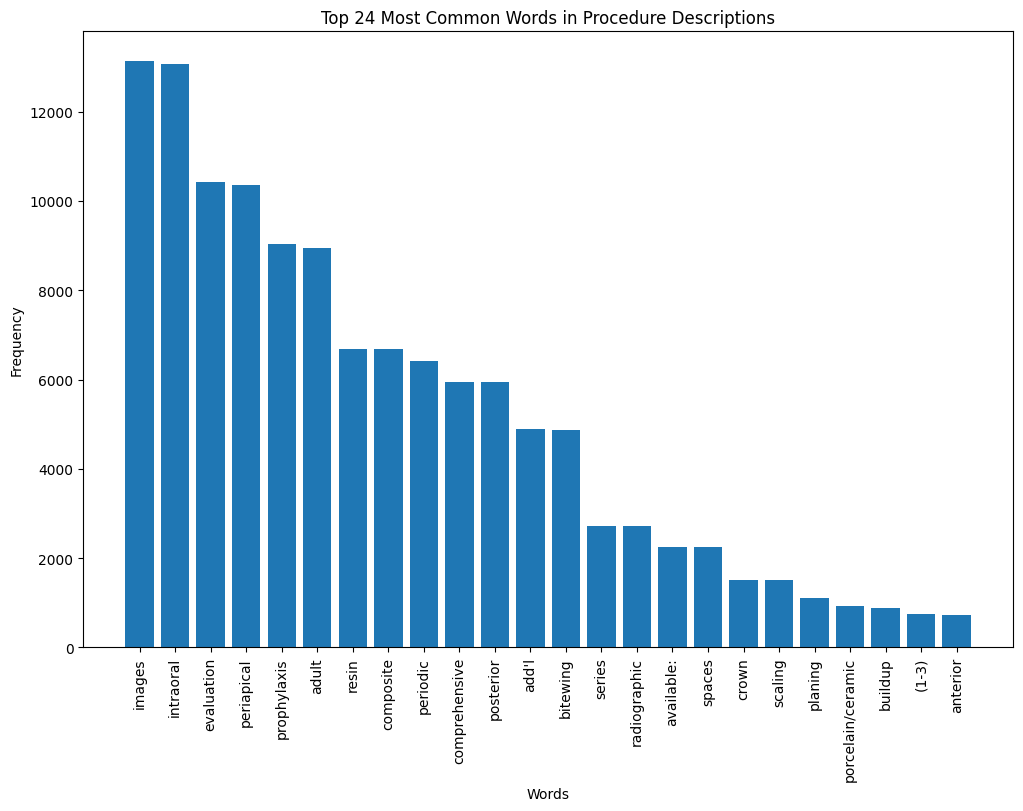

In [92]:
from collections import Counter
import itertools

# Extract all words from the 'Proc Description' column
words = df_t['Proc. Description'].str.lower().str.split().explode()

# Count the frequency of each word
word_counts = Counter(words)

# Find common substrings of whole words
common_words = {word: count for word, count in word_counts.items() if count > 1}

# Sort the common words by their frequency in descending order
sorted_common_words = dict(sorted(common_words.items(), key=lambda item: item[1], reverse=True))

print(sorted_common_words)
# Plot the top 24 words
top_24_words = dict(itertools.islice({word: count for word, count in sorted_common_words.items() if len(word) > 4}.items(), 24))

plt.figure(figsize=(12, 8))
plt.bar(top_24_words.keys(), top_24_words.values())
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 24 Most Common Words in Procedure Descriptions')
plt.show()

In [93]:
phrase_list = ['periodontal', 'evaluation', 'intraoral', 'periapical', 'prophylaxis', 'bitewing', 'resin', 'composite', 'porcelain', 'ceramic', 'images', 'arch', 'guard', 'gingival', 'fluoride', 'root', 'crown', 'buildup',
               'metal', 'replacement', 'noble', 'upper', 'lower', 'denture', 'retainer', 'medicaments','palliative', 'late', 'cancellation', 'orthodontic', 'extraction', 'posterior','anterior', 'panoramic', 'radiographic']

In [94]:
# Initialize the count columns for each word in the word list
for word in phrase_list:
    df_t[word] = df_t['Proc. Description'].str.contains(word, case=False, regex=False).astype(bool)

# Display the updated dataframe
print(df_t.head())

         Date              Patient  Ascend Patient ID   Chart Number  \
0  10/27/2019        Gabriel, Rami     14000002286456  Not Available   
1  06/21/2020       Barrios, James     14000002286515  Not Available   
2  10/08/2020      Greene, David E     14000002286843  Not Available   
3  10/08/2020         Koenig, Cody     14000002286781        CK5152H   
4  10/20/2020  Reiman, Stephanie M     14000002286454  Not Available   

             Category                  Proc. Code           Proc. Description  \
0  Charge Adjustments  Not Available: spaces etc.  Not Available: spaces etc.   
1  Charge Adjustments  Not Available: spaces etc.  Not Available: spaces etc.   
2  Charge Adjustments  Not Available: spaces etc.  Not Available: spaces etc.   
3  Charge Adjustments  Not Available: spaces etc.  Not Available: spaces etc.   
4  Charge Adjustments  Not Available: spaces etc.  Not Available: spaces etc.   

  Proc Treatment Area  Charges  Credits  ... medicaments  palliative   late  \
0

In [95]:
df_t.dtypes

Date                    object
Patient                 object
Ascend Patient ID        int64
Chart Number            object
Category                object
Proc. Code              object
Proc. Description       object
Proc Treatment Area     object
Charges                float64
Credits                float64
merge_key               object
neg_charges               bool
pos_credits               bool
periodontal               bool
evaluation                bool
intraoral                 bool
periapical                bool
prophylaxis               bool
bitewing                  bool
resin                     bool
composite                 bool
porcelain                 bool
ceramic                   bool
images                    bool
arch                      bool
guard                     bool
gingival                  bool
fluoride                  bool
root                      bool
crown                     bool
buildup                   bool
metal                     bool
replacem

In [96]:
# Calculate the correlation matrix
df_t_corr = df_t.copy()
df_t_corr = df_t_corr.drop(columns=['Charges', 'Credits', 'neg_charges', 'pos_credits', 'Patient', 'Proc. Description', 'Date', 'Ascend Patient ID', 'Chart Number', 'merge_key'])

df_t_corr_num = df_t_corr.select_dtypes(include=[np.number]).copy()
correlation_matrix = df_t_corr_num.corr()

# Find pairs of columns that are perfectly correlated
perfect_correlations = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if correlation_matrix.iloc[i, j] == 1.0:
            colname1 = correlation_matrix.columns[i]
            colname2 = correlation_matrix.columns[j]
            perfect_correlations.append((colname1, colname2))
    # Check for perfect binary or categorical relationships
for column in df_t_corr.select_dtypes(include=['object', 'category', 'bool']).columns:
    unique_values = df_t_corr[column].nunique()
    if unique_values == 2:
        for other_column in df_t_corr.select_dtypes(include=['object', 'category', 'bool']).columns:
            if column != other_column and df_t_corr.groupby(column)[other_column].nunique().max() == 1:
                perfect_correlations.append((column, other_column))

    # Print the pairs of perfectly correlated columns including binary or categorical relationships
    print("Perfectly correlated column pairs including binary or categorical relationships:")
    for pair in perfect_correlations:
        print(pair)

Perfectly correlated column pairs including binary or categorical relationships:
Perfectly correlated column pairs including binary or categorical relationships:
Perfectly correlated column pairs including binary or categorical relationships:
Perfectly correlated column pairs including binary or categorical relationships:
Perfectly correlated column pairs including binary or categorical relationships:
Perfectly correlated column pairs including binary or categorical relationships:
Perfectly correlated column pairs including binary or categorical relationships:
Perfectly correlated column pairs including binary or categorical relationships:
Perfectly correlated column pairs including binary or categorical relationships:
Perfectly correlated column pairs including binary or categorical relationships:
Perfectly correlated column pairs including binary or categorical relationships:
Perfectly correlated column pairs including binary or categorical relationships:
Perfectly correlated column 

In [97]:
df_t['Referral'] = df_t['Proc. Code'].str.startswith('REF')
df_t['Referral'].value_counts()

Referral
False    53516
True         2
Name: count, dtype: int64

In [98]:
transformed_data['transaction_details'] = df_t.copy()
transformed_data['transaction_details'].to_csv(f"{output_dir}/transformed_transaction_details.csv", index=False)

## Transformations for Treatment Tracker
- Add month grouping
- Remove test patients
- Remove canceled and/or invalidated (?)

In [99]:
df_t = dataframes['treatment_tracker'].copy()

In [100]:
transformed_data['treatment_tracker'] = df_t.copy()

## Transformations for Unresolved Claims
- Plans by carrier grouping
- Parse StateId
- Group by: Carrier, Plan

In [101]:
df_t = dataframes['unresolved_claims'].copy()

In [102]:
transformed_data['unresolved_claims'] = df_t.copy()

# Merge transformed data

In [103]:
# Merge the data
transformed_data
merged_df = transformed_data['patient_details'].copy()
for key in transformed_data:
        if key in ['statement_submission']:
                print(key)
                merged_df = merged_df.merge(transformed_data[key], on='Ascend Patient ID', how='left')

statement_submission


In [104]:
merged_df.to_csv(f"{output_dir}/merged_data.csv", index=False)

In [105]:
merged_df.head

<bound method NDFrame.head of                    Patient     Primary Guarantor       Primary Contact  \
0         Abelmann, Anders      Abelmann, Anders      Abelmann, Anders   
1             Aberle, Kyle          Aberle, Kyle          Aberle, Kyle   
2          Abrahms, Rhonda       Abrahms, Rhonda       Abrahms, Rhonda   
3      Abramowitz, Rebecca   Abramowitz, Rebecca   Abramowitz, Rebecca   
4              Abud, Kevin           Abud, Kevin           Abud, Kevin   
...                    ...                   ...                   ...   
3936       Zimbler, Daniel       Zimbler, Daniel       Zimbler, Daniel   
3937  Ziolkowski, Kimberly  Ziolkowski, Kimberly  Ziolkowski, Kimberly   
3938  Ziolkowski, Kimberly  Ziolkowski, Kimberly  Ziolkowski, Kimberly   
3939        zwick, emanuel         Zwick, Qinnan         Zwick, Qinnan   
3940         Zwick, Qinnan         Zwick, Qinnan         Zwick, Qinnan   

       Last Name Chart Number  Ascend Patient ID Date Of Birth  \
0       Abelman

In [106]:
merged_df.columns

Index(['Patient', 'Primary Guarantor', 'Primary Contact', 'Last Name',
       'Chart Number', 'Ascend Patient ID', 'Date Of Birth', 'Phone', 'Email',
       'Address', 'Status', 'First Visit', 'Last Visit', 'Last Procedure Date',
       'Next Appointment Date', 'Discount Plan', 'Pat. Prim. Fee Schedule',
       'Pat. Prim. Carrier', 'Pat. Prim. Plan', 'Prim. Subscriber ID',
       'merge_key_x', 'patientAge', 'student',
       'Lifespan (Today - First Visit)', 'Lifespan (Last Visit - First Visit)',
       'Lifespan (Next Appointment Date - First Visit)',
       'Time Since Last Visit', 'Visit and Procedure Mismatch',
       'hasNextAppointment', 'overdue', 'Affiliate State', 'Cleaned Carrier',
       'Street', 'City', 'State', 'ZIP Code', 'DCS', 'DNU', 'plan_name',
       'plan_name_cruft', 'university_or_college_plan',
       'Simplest_Equivalent_Plan', 'plan_name_diff', 'id', 'dateTime',
       'statementType', 'generatedFrom', 'balance', 'patient.id',
       'patient.firstName', 'pa

In [107]:
transformed_data['patient_details'].dtypes

Patient                                                   object
Primary Guarantor                                         object
Primary Contact                                           object
Last Name                                                 object
Chart Number                                              object
Ascend Patient ID                                          int64
Date Of Birth                                             object
Phone                                                     object
Email                                                     object
Address                                                   object
Status                                                    object
First Visit                                       datetime64[ns]
Last Visit                                        datetime64[ns]
Last Procedure Date                               datetime64[ns]
Next Appointment Date                             datetime64[ns]
Discount Plan            